In [26]:
import pandas as pd
from statistics import mean, stdev 

In [27]:
merchant_train = pd.read_csv('../data/curated/final_model/agg_fortnightly_mean_sd_marketcorr_train_NOFRAUD.csv')
merchant_validate = pd.read_csv('../data/curated/final_model/agg_fortnightly_mean_sd_marketcorr_validate_NOFRAUD.csv')
merchant_overall = pd.read_csv('../data/curated/final_model/agg_fortnightly_mean_sd_marketcorr_NOFRAUD.csv')

merchant_fortnight_train = pd.read_csv('../data/curated/final_model/fortnightly_agg_merchant_transactions_train_NOFRAUD.csv')
merchant_fortnight_validate = pd.read_csv('../data/curated/final_model/fortnightly_agg_merchant_transactions_validate_NOFRAUD.csv')
merchant_fortnight= pd.read_csv('../data/curated/final_model/fortnightly_agg_merchant_transactions_NOFRAUD.csv')

In [87]:
merchant_train

,merchant_abn,mean,stdev,n_periods,corr,covar,beta,score
0,10023283211,15512.362011,4086.131819,23,0.924841,4.582382e+10,0.000312,1.959942e+07
1,10142254217,2604.069884,890.801224,23,0.848513,9.165388e+09,0.000062,3.495720e+06
2,10187291046,887.664206,434.186394,23,0.356489,1.876871e+09,0.000013,1.322207e+06
3,10192359162,3947.807758,1859.597305,23,0.503911,1.136277e+10,0.000077,5.807909e+06
4,10206519221,8313.054705,2304.920626,23,0.945070,2.641385e+10,0.000180,1.061892e+07
...,...,...,...,...,...,...,...,...
4351,99938978285,11772.700720,2868.089506,23,0.978122,3.401712e+10,0.000231,1.464177e+07
4352,99974311662,823.751647,528.936751,23,0.301563,1.934166e+09,0.000013,1.352990e+06
4353,99976658299,78879.279709,20056.608039,23,0.983820,2.392682e+11,0.001627,9.893687e+07
4354,99987905597,1199.529244,674.596347,23,0.349577,2.859557e+09,0.000019,1.874475e+06


first write function that gets scores of all stores

In [38]:
merchant_overall = merchant_overall.fillna(0)
merchant_train = merchant_train.fillna(0)
merchant_validate = merchant_validate.fillna(0)

a_combo = [1, 1, 1]

def get_hscore(merchant_train, a_combo):
    merchant_train['score'] = a_combo[0] * merchant_train['mean'] + a_combo[1] * merchant_train['stdev'] \
        + a_combo[2] * merchant_train['corr']
    
    return merchant_train[['merchant_abn', 'score']]

In [40]:
merchants_train_score = get_hscore(merchant_train, a_combo)
merchants_train_score

,merchant_abn,score
0,10023283211,19599.418671
1,10142254217,3495.719620
2,10187291046,1322.207090
3,10192359162,5807.908974
4,10206519221,10618.920402
...,...,...
4351,99938978285,14641.768348
4352,99974311662,1352.989961
4353,99976658299,98936.871568
4354,99987905597,1874.475169


get top 100 and make into portfolio (just a list)

In [42]:
def get_portfolio_abn(merchants_train_score):
    sorted_merchants_train_score = merchants_train_score.sort_values(['score'], ascending=False)

    top_100_portfolio = sorted_merchants_train_score.head(100)

    top_portfolio_merchants = list(top_100_portfolio['merchant_abn'])

    return top_portfolio_merchants


In [45]:
top_portfolio_merchants = get_portfolio_abn(merchants_train_score)

Get Portfolio Stats (load periodic data and add up)
-own fortnightly E[r] and sd(r)
-calculate E(r) / sd(r)

In [46]:
def get_sharpe_ratio_of_portfolio(merchant_fortnight_validate, top_portfolio_merchants):
    top_100_portfolio_fortnightly = pd.DataFrame()

    for abn in top_portfolio_merchants:
        tmp = merchant_fortnight_validate[merchant_fortnight_validate['merchant_abn'] == abn]
        top_100_portfolio_fortnightly = pd.concat([top_100_portfolio_fortnightly, tmp])

    top_100_portfolio_fortnightly_agg = top_100_portfolio_fortnightly.groupby(['Year', 'Fortnight']).agg({'sum_transactions': mean})

    top_100_portfolio_fortnightly_mean = mean(top_100_portfolio_fortnightly_agg['sum_transactions'])
    top_100_portfolio_fortnightly_sd = stdev(top_100_portfolio_fortnightly_agg['sum_transactions'])

    portfolio_sharpe_ratio = top_100_portfolio_fortnightly_mean/top_100_portfolio_fortnightly_sd
    
    return portfolio_sharpe_ratio

In [47]:
portfolio_sharpe_ratio = get_sharpe_ratio_of_portfolio(merchant_fortnight_validate, top_portfolio_merchants)

In [48]:
portfolio_sharpe_ratio

8.329866490713195

then write loop for alphas

In [60]:
a_combos = []

a_values = [-10000, -100, -10, -1, -0.1, -0.01, -0.001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]

for a1 in a_values:
    for a2 in a_values:
        for a3 in a_values:
            a_combos.append([a1, a2, a3])

In [54]:
all_sharpe_ratios = list()


for a_combo in a_combos:
    merchants_train_score = get_hscore(merchant_train, a_combo)

    top_portfolio_merchants = get_portfolio_abn(merchants_train_score)

    portfolio_sharpe_ratio = get_sharpe_ratio_of_portfolio(merchant_fortnight_validate, top_portfolio_merchants)

    all_sharpe_ratios.append(portfolio_sharpe_ratio)

all_sharpe_ratios

[4.35274270880947,
 4.35274270880947,
 4.35274270880947,
 4.35274270880947,
 4.35274270880947,
 4.35274270880947,
 4.35274270880947,
 4.35274270880947,
 4.35274270880947,
 4.35274270880947,
 4.35274270880947,
 4.35274270880947,
 4.35274270880947,
 4.35274270880947,
 1.3892891523539768,
 1.3892891523539768,
 1.3892891523539768,
 1.3892891523539768,
 1.3892891523539768,
 1.3892891523539768,
 1.3892891523539768,
 1.3892891523539768,
 1.3892891523539768,
 1.3892891523539768,
 1.3892891523539768,
 1.3892891523539768,
 1.3892891523539768,
 1.3892891523539768,
 1.3069117277753486,
 1.3069117277753486,
 1.3069117277753486,
 1.3069117277753486,
 1.3069117277753486,
 1.3069117277753486,
 1.3069117277753486,
 1.3069117277753486,
 1.3069117277753486,
 1.3069117277753486,
 1.3069117277753486,
 1.3069117277753486,
 1.3069117277753486,
 1.3069117277753486,
 1.3069117277753486,
 1.3069117277753486,
 1.3069117277753486,
 1.3069117277753486,
 1.3069117277753486,
 1.3069117277753486,
 1.3069117277753486,

In [65]:
test = pd.DataFrame({'all_combos': a_combos, 'sharpe_ratio': all_sharpe_ratios}).sort_values(['sharpe_ratio'], ascending = False)

In [88]:
test.head(60)

,all_combos,sharpe_ratio
1818,"[0.1, -1, 100]",8.779210
1635,"[0.01, -0.1, 10]",8.779210
1452,"[0.001, -0.01, 1]",8.779210
2001,"[1, -10, 1000]",8.779210
1468,"[0.001, -0.001, 100]",8.340637
1651,"[0.01, -0.01, 1000]",8.340637
1665,"[0.01, -0.001, 1000]",8.340637
1833,"[0.1, -0.1, 1000]",8.333366
1650,"[0.01, -0.01, 100]",8.333366
1467,"[0.001, -0.001, 10]",8.333366


In [66]:
test.describe()

,sharpe_ratio
count,2744.000000
mean,6.046885
std,2.906921
min,1.076257
25%,2.034531
50%,7.505765
75%,8.317617
max,8.779210


array([[<AxesSubplot:title={'center':'sharpe_ratio'}>]], dtype=object)

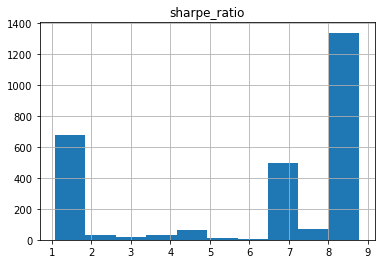

In [67]:
test.hist()